# Bay Wheels (Ford GoBike) System Data
### by Wei Chong Ong

## Preliminary Wrangling

> This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. Note that this dataset will require some data wrangling in order to make it tidy for analysis. There are multiple cities covered by the linked system, and multiple data files will need to be joined together if a full year’s coverage is desired. If you’re feeling adventurous, try adding in analysis from other cities, following links from [this page](https://www.bikeshare.com/data/) or [this page](https://github.com/BetaNYC/Bike-Share-Data-Best-Practices/wiki/Bike-Share-Data-Systems).

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import glob

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

Motivation: In this project, I investigate Bay Wheels (Ford GoBike) public datasets. [Bay Wheels](https://en.wikipedia.org/wiki/Bay_Wheels) is a regional public bicycle sharing system in California's San Francisco Bay Area. Bay Wheels is the first regional and large-scale bicycle sharing system deployed in California and on the West Coast of the United States. 

The objective of this study is to investigate the trip characteristics and bike activity patterns, for Bay Wheels's public bicycle sharing system during a seven-month period. 

Since April, Bay Wheels changed the structure of their public dataset by including the rideable type (electric or docked bike). Therefore, I will the data starting from April 2020 until October 2020 for consistency purpose. I download the datasets for each months from its [website](https://www.lyft.com/bikes/bay-wheels/system-data) and concatenate them into one single master dataset. The public dataset includes information about individual rides made in a bike-sharing system covering three Californa's cities: San Francisco, San Jose and Oakland.

I create visualizations and communicate the findings for the following topics:
- When are most trips taken in terms of time of day, day of the week, or month of the year?
- How long does the average trip take?
- Does the above depend on if a user is a subscriber or customer? “Subscriber” = Member or “Customer” = Casual
- By city

### Import data

In [2]:
df_master = pd.DataFrame()
for dataset in glob.glob('datasets_2020/*.csv'):
    df_master = pd.concat([df_master, pd.read_csv(dataset)])

# Drop 'is_equity' column as it exists only in the May dataset    
df_master = df_master.drop('is_equity', axis=1)

### Assess data 

In [3]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999385 entries, 0 to 154966
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             999385 non-null  object 
 1   rideable_type       999385 non-null  object 
 2   started_at          999385 non-null  object 
 3   ended_at            999385 non-null  object 
 4   start_station_name  671714 non-null  object 
 5   start_station_id    671714 non-null  float64
 6   end_station_name    653542 non-null  object 
 7   end_station_id      653542 non-null  float64
 8   start_lat           999385 non-null  float64
 9   start_lng           999385 non-null  float64
 10  end_lat             997971 non-null  float64
 11  end_lng             997971 non-null  float64
 12  member_casual       999385 non-null  object 
dtypes: float64(6), object(7)
memory usage: 106.7+ MB


In [4]:
df_master.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C1625FB41A8A7211,electric_bike,2020-10-15 20:20:22,2020-10-15 21:25:22,NaN,NaN,NaN,NaN,37.72000,-122.480000,37.720000,-122.480000,casual
1,4EBA90C255647B88,electric_bike,2020-10-15 21:38:42,2020-10-15 22:29:09,NaN,NaN,Eucalyptus Dr at 20th Ave,540.0,37.72000,-122.480000,37.731099,-122.476259,casual
2,15F0AF77290C3633,electric_bike,2020-10-16 02:32:08,2020-10-16 02:46:00,NaN,NaN,Harrison St at 20th St,129.0,37.79000,-122.420000,37.758872,-122.412564,casual
3,E9B0145885B8EFCF,electric_bike,2020-10-15 19:19:04,2020-10-15 20:17:59,Holloway Ave at Arellano Ave,541.0,NaN,NaN,37.72096,-122.478832,37.720000,-122.480000,casual
4,B536402782E8EF05,electric_bike,2020-10-16 16:22:25,2020-10-16 16:54:46,Pierce St at Haight St,73.0,Powell St at Columbus Ave,487.0,37.77182,-122.433799,37.800436,-122.410915,casual


In [5]:
df_master[df_master['end_lat'].isnull()]['rideable_type'].value_counts()

docked_bike    1414
Name: rideable_type, dtype: int64

In [6]:
df_master[df_master['end_station_id'].isnull()]['rideable_type'].value_counts()

electric_bike    344429
docked_bike        1414
Name: rideable_type, dtype: int64

> - 1414 rows for docked bike: I assume that the trips start and end at the same station.

In [7]:
df_master[df_master['start_station_id'].isnull()]['rideable_type'].value_counts()

electric_bike    327671
Name: rideable_type, dtype: int64

> - There is no station info for electric bike because they are dockless.

> Data Quality issue:
>- Incorrect datatypes: `started_at`, `ended_at`, `start_station_id`, `end_station_id`

In [8]:
#df_master.to_csv('bay_wheels_master.csv', index = False)

### Clean data

In [9]:
df_master_clean = df_master.copy()

In [10]:
df_master_clean['started_at'] = pd.to_datetime(df_master_clean['started_at'])
df_master_clean['ended_at'] = pd.to_datetime(df_master_clean['ended_at'])
df_master_clean['start_station_id'] = df_master_clean['start_station_id'].astype(str)
df_master_clean['end_station_id'] = df_master_clean['end_station_id'].astype(str)

### Feature Engineering

#### Create `city` feature

In [11]:
bin_edges = [-122.6, -122.3, -122.2, -121.7]
bin_labels = ['san_francisco', 'oakland', 'san_jose']
df_master_clean['city'] = pd.cut(df_master_clean['start_lng'], bin_edges, labels=bin_labels)

In [12]:
df_master_clean['city'].isnull().sum()

0

#### Create `month_of_the_year` , `day_of_the_week`, `time_of_day` feature

In [13]:
df_master_clean['month_of_the_year'] = df_master_clean['started_at'].dt.month
df_master_clean['day_of_the_week'] = df_master_clean['started_at'].dt.weekday 
df_master_clean['week_period'] = df_master_clean['day_of_the_week'].map({0:'weekday',
                                                                         1:'weekday',
                                                                         2:'weekday',
                                                                         3:'weekday',
                                                                         4:'weekday',
                                                                         5:'weekend',
                                                                         6:'weekend'})
df_master_clean['day_of_the_week'] = df_master_clean['day_of_the_week'].map({0:'monday',
                                                                         1:'tuesday',
                                                                         2:'wednesday',
                                                                         3:'thursday',
                                                                         4:'friday',
                                                                         5:'saturday',
                                                                         6:'sunday'})

In [14]:
df_master_clean['hour_of_the_day'] = df_master_clean['started_at'].dt.hour
# df_master_clean['minute'] = df_master_clean['started_at'].dt.minute 

# # split timestamp into hour and minutes
# df_master_clean['time_in_min'] = df_master_clean['hour_of_the_day']*60 + df_master_clean['minute']

# # There are 24 hrs in a day, so we can split these hours into 4 sections
# bin_edges = [-0.1, 6*60, 12*60, 18*60, 24*60]       # -0.1 instead of 0 to include 0 time_in_min e.g. 00:00:12
# bin_labels = ['overnight', 'morning', 'afternoon', 'evening']
# df_master_clean['time_of_day'] = pd.cut(df_master_clean['time_in_min'], bin_edges, labels=bin_labels)

#### Create `duration` feature in minute

In [15]:
df_master_clean['duration'] = (df_master_clean['ended_at'] - df_master_clean['started_at']) / pd.Timedelta(minutes=1)

In [16]:
df_master_clean['duration']

0         65.000000
1         50.450000
2         13.866667
3         58.916667
4         32.350000
            ...    
154962    12.400000
154963    43.066667
154964    52.966667
154965    75.766667
154966    11.416667
Name: duration, Length: 999385, dtype: float64

In [17]:
# Only keep rows with positive ride_duration_in_min
df_master_clean = df_master_clean[df_master_clean['duration'] > 0]

In [18]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998328 entries, 0 to 154966
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             998328 non-null  object        
 1   rideable_type       998328 non-null  object        
 2   started_at          998328 non-null  datetime64[ns]
 3   ended_at            998328 non-null  datetime64[ns]
 4   start_station_name  670663 non-null  object        
 5   start_station_id    998328 non-null  object        
 6   end_station_name    652647 non-null  object        
 7   end_station_id      998328 non-null  object        
 8   start_lat           998328 non-null  float64       
 9   start_lng           998328 non-null  float64       
 10  end_lat             996921 non-null  float64       
 11  end_lng             996921 non-null  float64       
 12  member_casual       998328 non-null  object        
 13  city                998328 no

# Exploratory Data Analysis

### What is the structure of your dataset?

> The are 998328 ride activites in the cleaned dataset with 21 features containing the information about each individual rides. 

### What is/are the main feature(s) of interest in your dataset?

> The `started_at` and `ended_at` are the main features in this project as they contain information about the time of day, day of the week, or month of the year. I'm most interested in figuring out what features play an important role in affecting the **ride duration**.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> These categorical features `rideable_type`, `city`, `member_casual` will help me to determine which bike type is the most popular, which city has the most users and what type of users is using the service more often.

In [19]:
df_master_clean.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'city', 'month_of_the_year', 'day_of_the_week',
       'week_period', 'hour_of_the_day', 'duration'],
      dtype='object')

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

In [20]:
base_color = sns.color_palette()[0]

In [21]:
# cat_vars = ['rideable_type', 'member_casual', 'city', 'month', 'day_of_the_week', 'week_period', 'hour', 'time_of_day']
categorical_vars = ['rideable_type', 'member_casual', 'city', 'month_of_the_year', 'day_of_the_week', 'hour_of_the_day']

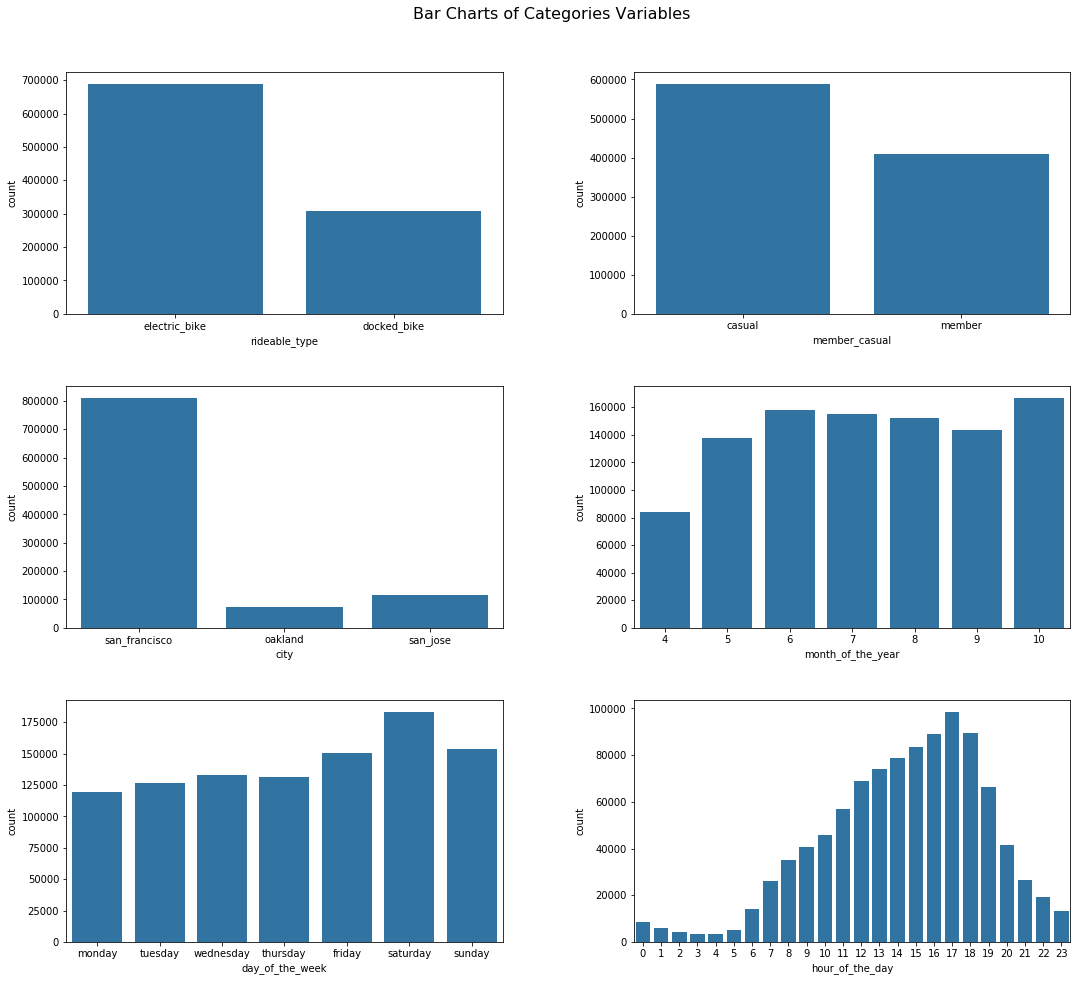

In [22]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
i=1
for cat in categorical_vars:
    ax = fig.add_subplot(3, 2, i)
    if cat == 'day_of_the_week':
        ax = sns.countplot(data = df_master_clean, x = cat, color=base_color, 
                           order = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'])
    else:
        ax = sns.countplot(data = df_master_clean, x = cat, color=base_color)
    i+=1
fig.suptitle('Bar Charts of Categories Variables', ha='center', va='center', fontsize=16, y=0.93);

> Findings:
- The number of electric bike used is more than twice the number of docked bike.
- Interestingly, there are more casual users than the member users.
- The majority of the users are in San Francisco, with 8 times more than Oakland and San Jose.
- Over the year of 2020, more and more people were using the bicycle sharing system in California. From April to October, the number of users has doubled.
- Saturday has the highest number of trips compared to other days.
- The number of rides increases gradually from 5am until the evening with the peak at 5pm.

> Plan on investigating next:
-  

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

In [23]:
df_master_clean['duration'].describe()

count    998328.000000
mean         26.365114
std         345.031450
min           0.016667
25%           7.133333
50%          12.700000
75%          22.566667
max       54728.866667
Name: duration, dtype: float64

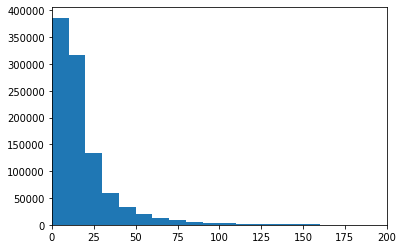

In [24]:
bins = np.arange(0, df_master_clean['duration'].max() + 10, 10)
plt.hist(data = df_master_clean, x = 'duration', bins = bins)
plt.xlim(0,200);

> There's a long tail in the distribution due to the very large range of values. It is better to visualize this kind of data by performing log transformation on the x-axis.

In [25]:
np.log10(df_master_clean['duration']).describe()

count    998328.000000
mean          1.081176
std           0.471322
min          -1.778151
25%           0.853293
50%           1.103804
75%           1.353467
max           4.738216
Name: duration, dtype: float64

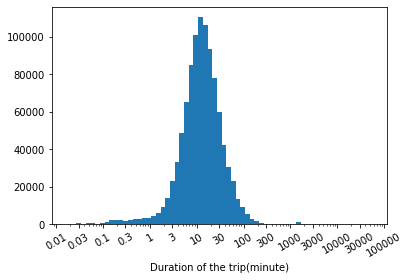

In [26]:
# Get the ticks for bins between [0 - maximum weight]
bins = 10 ** np.arange(-1.77, 4.7+0.1, 0.1)

# Generate the x-ticks you want to apply
ticks = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000]

# Convert ticks into string values, to be displaye dlong the x-axis
labels = ['{}'.format(v) for v in ticks]

# Plot the histogram
plt.hist(data = df_master_clean, x = 'duration', bins = bins)
plt.xscale('log')

# Apply x-ticks
plt.xticks(ticks, labels, rotation = 30)

# Apply labels
plt.xlabel('Duration of the trip(minute)');

> Again, it shows that there is a very wide range of values in the ride duration, from a minimum of `0.017 min` to a maximum of more than `50000 mins`. Median is `12.7 mins` and mean is `26.4 mins`, which means that the data is right skewed. Nevertheless, the data is almost normal distributed in log scale. 

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

1. For docked bikes: Average ride duration of O-O vs O-D -> Adapted bar chart or pointplot with standard deviation
2. log ride duration vs month -> Scatterplot with x_jitter and alpha
3. log ride duration vs cat: violinplot
4. week period vs time of the day (cat vs cat): clustered bar charts sns.countplot()
5. log ride duration vs time of the day: histogram of quantitative variable against the qualitative subsets of the data: faceting

### How duration of the trip correlate with the categorical variables?

In [27]:
def log_trans(x, inverse = False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

df_master_clean['log_duration'] = df_master_clean['duration'].apply(log_trans)

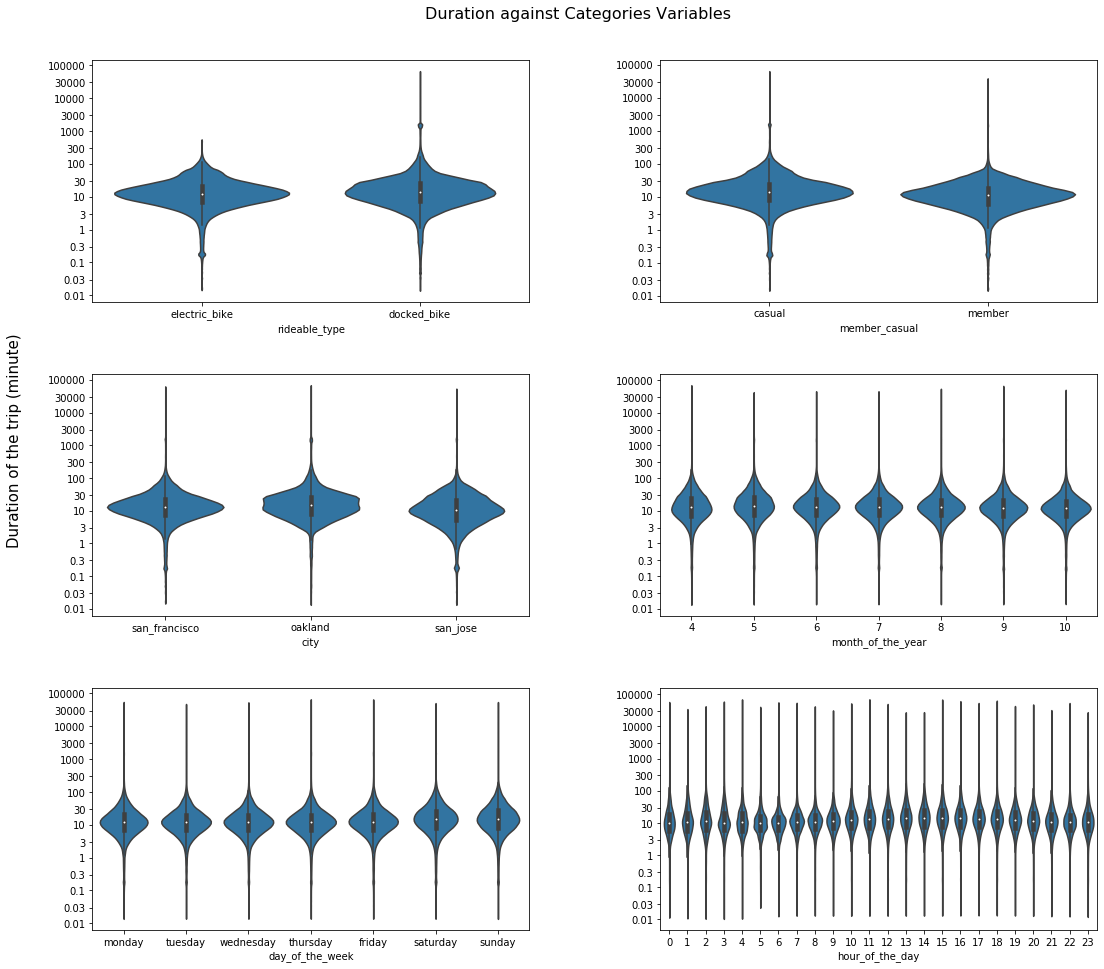

In [28]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
i=1
for cat in categorical_vars:
    ax = fig.add_subplot(3, 2, i)
    if cat == 'day_of_the_week':
        ax = sns.violinplot(data = df_master_clean, x = cat, y = 'log_duration', color = base_color, 
                            order = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'])
    else:
        ax = sns.violinplot(data = df_master_clean, x = cat, y = 'log_duration', color = base_color)
    ax.set_yticks(log_trans(ticks))
    ax.set_yticklabels(labels)
    ax.set_ylabel('')
    i+=1

fig.suptitle('Duration against Categories Variables', ha='center', va='center', fontsize=16, y=0.92)
fig.text(0.065, 0.55,'Duration of the trip (minute)', ha='center', va='center', rotation='vertical', fontsize=15)
plt.show()

> Findings:
- Interestingly, the average duration of the trip is similar and around 12 minutes no matter where the starting point is, when is the trip is, who the user is and which type of the bike is.

In [29]:
# To avoid the trap of the categorical variables being associated with very long or very short trip duration, we should focus our visualization on only a small range of duration. -> 1 min to 300 mins
# df_master_clean_sub = df_master_clean[(df_master_clean['duration']>=1) & (df_master_clean['duration']<=300)]

In [30]:
# ticks_sub = [1, 3, 10, 30, 100, 300]
# labels_sub = ['{}'.format(v) for v in ticks_sub]

In [31]:
# fig = plt.figure(figsize=(18,16))
# fig.subplots_adjust(wspace=0.3, hspace=0.3)
# i=1
# for cat in categorical_vars:
#     ax = fig.add_subplot(3, 2, i)
#     if cat == 'day_of_the_week':
#         ax = sns.violinplot(data = df_master_clean_sub, x = cat, y = 'log_duration', color = base_color, 
#                             order = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'])
#     else:
#         ax = sns.violinplot(data = df_master_clean_sub, x = cat, y = 'log_duration', color = base_color)
#     ax.set_yticks(log_trans(ticks_sub))
#     ax.set_yticklabels(labels_sub)
#     ax.set_ylabel('')
#     i+=1

# fig.suptitle('Duration against Categories Variables', ha='center', va='center', fontsize=16, y=0.92)
# fig.text(0.065, 0.55,'Duration of the trip (minute)', ha='center', va='center', rotation='vertical', fontsize=15)
# plt.show()

In [32]:
# sns.regplot(data = df_master_clean, x = 'hour_of_the_day', y = 'log_duration', truncate=False, x_jitter=0.3, scatter_kws={'alpha':1/20});

In [33]:
# bins = 10 ** np.arange(-1.77, 4.7+0.1, 0.1)
# g = sns.FacetGrid(data = df_master_clean, col = 'time_of_day', col_wrap = 2, height = 4)
# g.map(plt.hist, 'duration', bins=bins)
# g.set(xscale = 'log')
# g.set(xticks = ticks, xticklabels = ticks)
# g.set_xticklabels(rotation=30);

### Take a look at some of the relationships between the independent variables

In [34]:
categorical_vars

['rideable_type',
 'member_casual',
 'city',
 'month_of_the_year',
 'day_of_the_week',
 'hour_of_the_day']

There are 15 combinations of bivariate plot for 6 categorical variables. However, I create only the most meaningful plots that I can gain insights from.

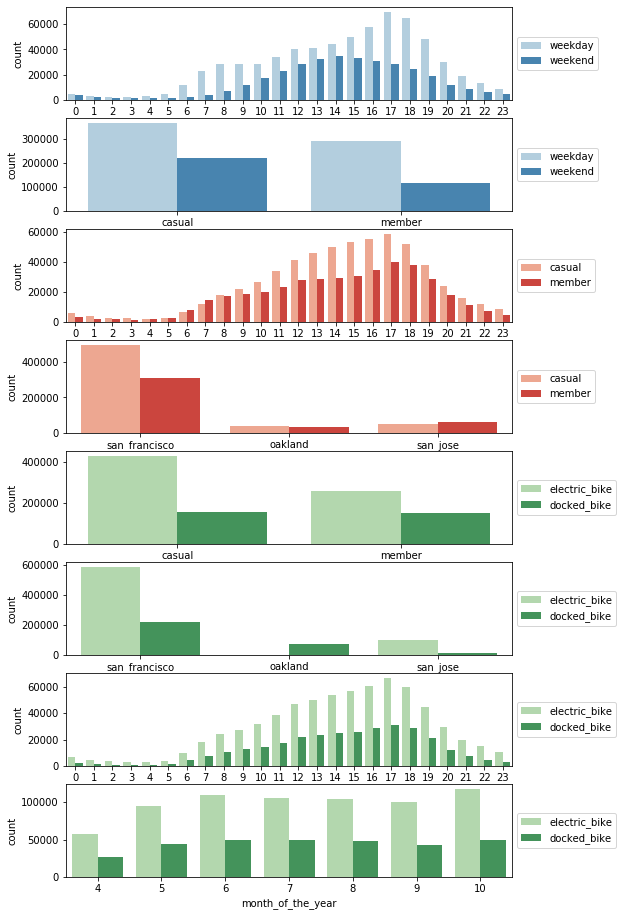

In [54]:
# since there's only three subplots to create, using the full data should be fine.
plt.figure(figsize = [8, 16])
n = 8

# Week Period vs Hour
ax = plt.subplot(n, 1, 1)
sns.countplot(data = df_master_clean, x = 'hour_of_the_day', hue = 'week_period', palette = 'Blues')
ax.legend(loc = 6, bbox_to_anchor = (1.0, 0.5))

# Membership vs Week Period
ax = plt.subplot(n, 1, 2)
sns.countplot(data = df_master_clean, x = 'member_casual', hue = 'week_period', palette = 'Blues')
ax.legend(loc = 6, bbox_to_anchor = (1.0, 0.5))

# Hour vs Membership 
ax = plt.subplot(n, 1, 3)
sns.countplot(data = df_master_clean, x = 'hour_of_the_day', hue = 'member_casual', palette = 'Reds')
ax.legend(loc = 6, bbox_to_anchor = (1.0, 0.5))

# City vs Membership 
ax = plt.subplot(n, 1, 4)
sns.countplot(data = df_master_clean, x = 'city', hue = 'member_casual', palette = 'Reds')
ax.legend(loc = 6, bbox_to_anchor = (1.0, 0.5))

# Membership vs Rideable Type
ax = plt.subplot(n, 1, 5)
sns.countplot(data = df_master_clean, x = 'member_casual', hue = 'rideable_type', palette = 'Greens')
ax.legend(loc = 6, bbox_to_anchor = (1.0, 0.5))

# City vs Rideable Type
ax = plt.subplot(n, 1, 6)
sns.countplot(data = df_master_clean, x = 'city', hue = 'rideable_type', palette = 'Greens')
ax.legend(loc = 6, bbox_to_anchor = (1.0, 0.5)) 

# Month vs Rideable Type
ax = plt.subplot(n, 1, 7)
sns.countplot(data = df_master_clean, x = 'hour_of_the_day', hue = 'rideable_type', palette = 'Greens')
ax.legend(loc = 6, bbox_to_anchor = (1.0, 0.5))

# Month vs Rideable Type
ax = plt.subplot(n, 1, 8)
sns.countplot(data = df_master_clean, x = 'month_of_the_year', hue = 'rideable_type', palette = 'Greens')
ax.legend(loc = 6, bbox_to_anchor = (1.0, 0.5))

plt.show()

> Findings:
- During weekdays, the peak is at around 5pm to 6pm and this is the off-work time for most of the people. On the other hand, most of the trips are from 1 to 3pm during the weekends.
- There is a similar pattern for both member and casual throughout the day. However, I think it's worth to point out between 6am and 7am in the morning is the only period, where members are using the service more than non-members. We could say that the reason of those people subscribed is that they want to use shared bike as a transportation to work. This statement is supported by the diagram above (Membership vs Week Period).
- The proprotion of docked bike is higher for people with membership.
- There is no electric bike in Oakland. The number of people used electric bike is three times the number of people used docked bike in San Francisco. And the difference is even larger in San Jose. Electric bike is more popular in California. This statement is validated once again from what we see in the last two diagrams where the usage of electric bike almost twice more frequent than docked bike for every hours of the day and every months in 2020.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!